In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect # add 'inspect' functionality

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Save references to each table
measurement_ref = Base.classes.measurement
station_ref = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Create an inspector to begin inspecting the data
inspector = inspect(engine)
inspector.get_table_names()
station_columns = inspector.get_columns('station')
measurement_columns = inspector.get_columns('measurement')

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(measurement_ref.date)).one()
latest_date

('2017-08-23',)

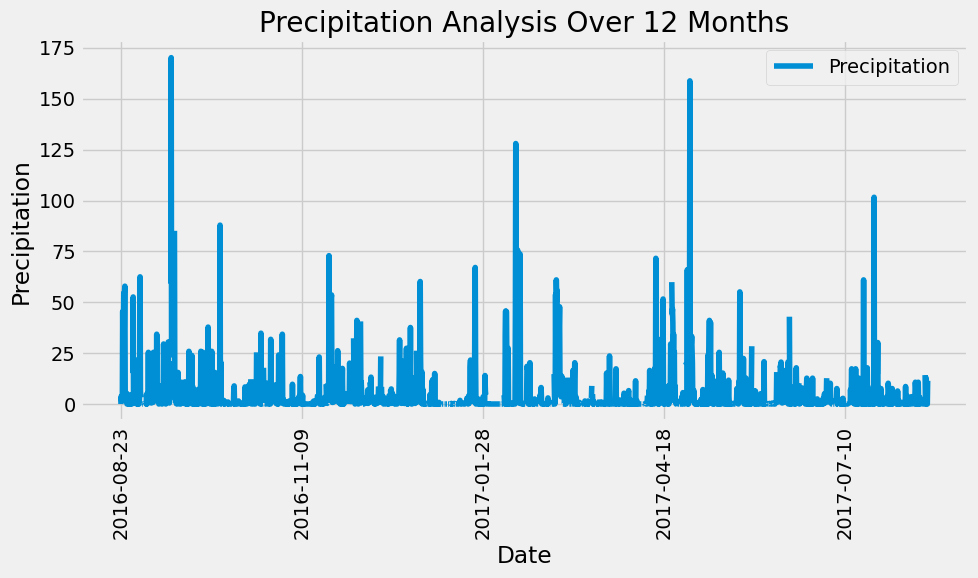

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_string = latest_date[0].split('-')

# Convert latest_date to a datetime object
datetime_date = dt.datetime(
    int(most_recent_date_string[0]),
    int(most_recent_date_string[1]),
    int(most_recent_date_string[2]))

# Calculate the date one year from the last date in data set.
previous_year_date = datetime_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement_ref.date, measurement_ref.prcp).\
    filter(measurement_ref.date >= previous_year_date).\
    order_by(measurement_ref.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(
    precipitation_data,
    columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis Over 12 Months")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station_ref.id)).all()
total_stations

[(9,)]

In [46]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
select_station = session.query(func.count(station_ref.id)).all()

# List the stations and their counts in descending order.
station_activity = session.query(measurement_ref.station, func.count(measurement_ref.station)).\
                   group_by(measurement_ref.station).\
                   order_by(func.count(measurement_ref.station).desc()).all() # Desc: displays the highest to lowest results
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0]

# Calculate lowest temperature
lowest_temp_query = session.query(func.min(measurement_ref.tobs)).filter(measurement_ref.station == most_active_station)
lowest_temp = lowest_temp_query.all()[0][0]

# Calculate highest temperature for the most-active station
highest_temp_query = session.query(func.max(measurement_ref.tobs)).filter(measurement_ref.station == most_active_station)
highest_temp = highest_temp_query.all()[0][0]

# Calculate average temperature for the most-active station
avg_temp_query = session.query(func.avg(measurement_ref.tobs)).filter(measurement_ref.station == most_active_station)
avg_temp = avg_temp_query.all()[0][0]

result = [(lowest_temp, highest_temp, avg_temp)]
result

[(12.2, 29.4, 22.03582251082252)]

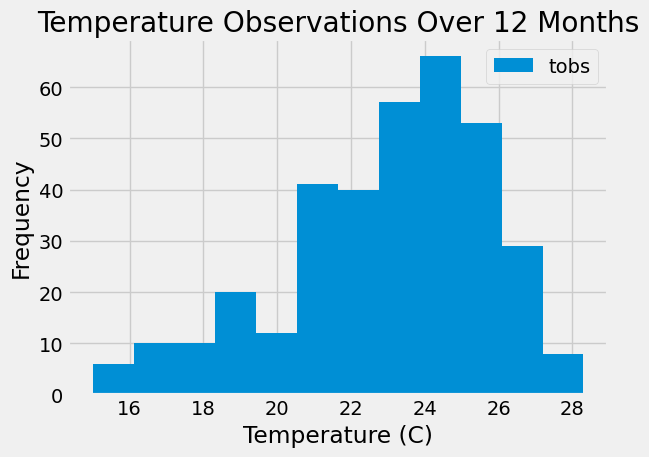

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement_ref.tobs).\
            filter(measurement_ref.date >= previous_year_date).\
            filter(measurement_ref.station == most_active_station).all()

# Extract the temperature observations from the query results
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel("Temperature (C)")
plt.ylabel("Frequency")
plt.title("Temperature Observations Over 12 Months")
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [61]:
# Close Session
session.close()